# RegularNet

In [1]:
#Load necessary libraries
import tensorflow as tf
import numpy as np
import tensorflow.contrib.slim as slim
import input_data
import matplotlib.pyplot as plt
%matplotlib inline

### Load CIFAR Dataset

To obtain the CIFAR10 dataset, go here: https://www.cs.toronto.edu/~kriz/cifar.html

The training data is stored in 5 separate files, and we will alternate between them during training.

In [2]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

In [3]:
currentCifar = 1
cifar = unpickle('./cifar10/data_batch_1')
cifarT = unpickle('./cifar10/test_batch')

In [4]:
total_layers = 25 #Specify how deep we want our network
units_between_stride = total_layers / 5

## RegularNet
A Deep Neural Network composed exclusively of regular and strided convolutional layers. While this architecture works well for relatively shallow networks, it becomes increasingly more difficult to train as the network depth increases.

In [5]:
tf.reset_default_graph()

input_layer = tf.placeholder(shape=[None,32,32,3],dtype=tf.float32,name='input')
label_layer = tf.placeholder(shape=[None],dtype=tf.int32)
label_oh = slim.layers.one_hot_encoding(label_layer,10)

layer1 = slim.conv2d(input_layer,64,[3,3],normalizer_fn=slim.batch_norm,scope='conv_'+str(0))
for i in range(5):
    for j in range(units_between_stride):
        layer1 = slim.conv2d(layer1,64,[3,3],normalizer_fn=slim.batch_norm,scope='conv_'+str((j+1) + (i*units_between_stride)))
    layer1 = slim.conv2d(layer1,64,[3,3],stride=[2,2],normalizer_fn=slim.batch_norm,scope='conv_s_'+str(i))
    
top = slim.conv2d(layer1,10,[3,3],normalizer_fn=slim.batch_norm,activation_fn=None,scope='conv_top')

output = slim.layers.softmax(slim.layers.flatten(top))

loss = tf.reduce_mean(-tf.reduce_sum(label_oh * tf.log(output) + 1e-10, axis=[1]))
trainer = tf.train.AdamOptimizer(learning_rate=0.001)
update = trainer.minimize(loss)

### Visualize the network graph
We can call the Tensorflow Board to provide a graphical representation of our network.

In [7]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [8]:
show_graph(tf.get_default_graph().as_graph_def())

## Training

In [13]:
init = tf.global_variables_initializer()
batch_size = 64
currentCifar = 1
total_steps = 20000
l = []
a = []
aT = []
saver = tf.train.Saver()
sess = tf.Session()
sess.run(init)
i = 0
draw = range(10000)
while i < total_steps:
    if i % (10000/batch_size) != 0:
        batch_index = np.random.choice(draw,size=batch_size,replace=False)
    else:
        draw = range(10000)
        if currentCifar == 5:
            currentCifar = 1
            print "Switched CIFAR set to " + str(currentCifar)
        else:
            currentCifar = currentCifar + 1
            print "Switched CIFAR set to " + str(currentCifar)
        cifar = unpickle('./cifar10/data_batch_'+str(currentCifar))
        batch_index = np.random.choice(draw,size=batch_size,replace=False)
    x = cifar['data'][batch_index]
    x = np.reshape(x,[batch_size,32,32,3],order='F')
    x = (x/256.0)
    x = (x - np.mean(x,axis=0)) / np.std(x,axis=0)
    y = np.reshape(np.array(cifar['labels'])[batch_index],[batch_size,1])
    _,lossA,yP,LO = sess.run([update,loss,output,label_oh],feed_dict={input_layer:x,label_layer:np.hstack(y)})
    accuracy = np.sum(np.equal(np.hstack(y),np.argmax(yP,1)))/float(len(y))
    l.append(lossA)
    a.append(accuracy)
    if i % 10 == 0: print "Step: " + str(i) + " Loss: " + str(lossA) + " Accuracy: " + str(accuracy)
    if i % 100 == 0: 
        point = np.random.randint(0,10000-500)
        xT = cifarT['data'][point:point+500]
        xT = np.reshape(xT,[500,32,32,3],order='F')
        xT = (xT/256.0)
        xT = (xT - np.mean(xT,axis=0)) / np.std(xT,axis=0)
        yT = np.reshape(np.array(cifarT['labels'])[point:point+500],[500])
        lossT,yP = sess.run([loss,output],feed_dict={input_layer:xT,label_layer:yT})
        accuracy = np.sum(np.equal(yT,np.argmax(yP,1)))/float(len(yT))
        aT.append(accuracy)
        print "Test set accuracy: " + str(accuracy)
    i+= 1
save_path = saver.save(sess, "./trainingmodels/model_regularnet.ckpt")
print "Model saved in file: " + str(save_path)
sess.close()

Switched CIFAR set to 2
Step: 0 Loss: 2.65189 Accuracy: 0.140625
Test set accuracy: 0.094
Step: 10 Loss: 2.34946 Accuracy: 0.0625
Step: 20 Loss: 2.28144 Accuracy: 0.140625
Step: 30 Loss: 2.2987 Accuracy: 0.109375
Step: 40 Loss: 2.18813 Accuracy: 0.234375
Step: 50 Loss: 2.17167 Accuracy: 0.125
Step: 60 Loss: 2.14698 Accuracy: 0.09375
Step: 70 Loss: 2.14901 Accuracy: 0.1875
Step: 80 Loss: 2.15305 Accuracy: 0.203125
Step: 90 Loss: 1.95596 Accuracy: 0.234375
Step: 100 Loss: 1.95966 Accuracy: 0.296875
Test set accuracy: 0.224
Step: 110 Loss: 1.94468 Accuracy: 0.3125
Step: 120 Loss: 2.10648 Accuracy: 0.15625
Step: 130 Loss: 1.94548 Accuracy: 0.21875
Step: 140 Loss: 2.12088 Accuracy: 0.1875
Step: 150 Loss: 1.92029 Accuracy: 0.28125
Switched CIFAR set to 3
Step: 160 Loss: 2.06548 Accuracy: 0.171875
Step: 170 Loss: 2.04632 Accuracy: 0.203125
Step: 180 Loss: 1.85713 Accuracy: 0.296875
Step: 190 Loss: 1.80789 Accuracy: 0.265625
Step: 200 Loss: 1.9017 Accuracy: 0.296875
Test set accuracy: 0.286
St

## Results

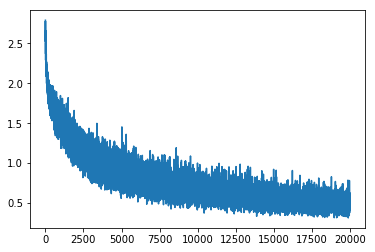

In [8]:
plt.plot(l) #Plot training loss

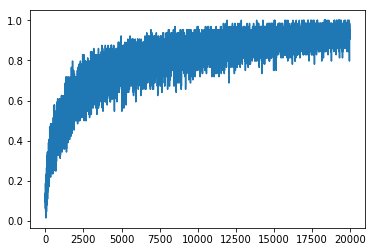

In [9]:
plt.plot(a) #Plot training accuracy

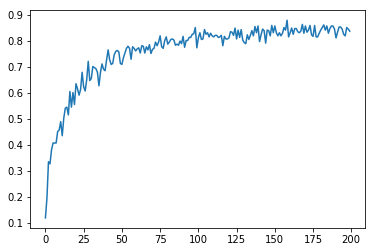

In [10]:
plt.plot(aT) #Plot test accuracy

In [20]:
np.max(aT) #Best test accuracy

0.88800000000000001

In [21]:
np.seterr(divide='ignore', invalid='ignore')
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./trainingmodels/model_regularnet.ckpt")
    print "Model restored."
    xT = cifarT['data'][0:0+500]
    xT = np.reshape(xT,[500,32,32,3],order='F')
    xT = (xT/256.0)
    xT = (xT - np.mean(xT,axis=0)) / np.std(xT,axis=0)
    yT = np.reshape(np.array(cifarT['labels'])[0:0+500],[500])
    lossT,yP = sess.run([loss,output],feed_dict={input_layer:xT,label_layer:yT})
    accuracy = np.sum(np.equal(yT,np.argmax(yP,1)))/float(len(yT))
    aT.append(accuracy)
    print "Test set accuracy: " + str(accuracy)

INFO:tensorflow:Restoring parameters from ./trainingmodels/model_regularnet.ckpt
Model restored.
Test set accuracy: 0.868
